In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ast
import json

# Computation of aggregated audio features by genre

In [2]:
path = "../data/"
artists = pd.read_csv(path+"artists.csv")
tracks = pd.read_csv(path+"tracks.csv")

In [3]:
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [4]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [5]:
# Convert release date to only the year
tracks['release_date'] = pd.to_datetime(tracks['release_date'], errors='raise')
tracks['release_date'] = tracks['release_date'].dt.strftime('%Y')

## All genres

In [6]:
features = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]

In [7]:
count = tracks['id'].count()
stats = tracks[['release_date'] + features].groupby('release_date').mean()
stats

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence
release_date,,,,,,,
1900,0.659000,0.791000,0.029500,0.139000,0.000002,0.161000,0.956000
1922,0.533320,0.324054,0.246295,0.898857,0.324971,0.250670,0.563605
1923,0.637332,0.266977,0.552072,0.859965,0.157659,0.225396,0.671967
1924,0.593344,0.356725,0.375208,0.866266,0.339628,0.203447,0.554935
1925,0.617391,0.263749,0.305693,0.912170,0.275384,0.255157,0.635196
...,...,...,...,...,...,...,...
2017,0.624972,0.659730,0.100517,0.278547,0.089228,0.200736,0.493965
2018,0.634510,0.652202,0.108212,0.278446,0.098398,0.198216,0.483251
2019,0.649724,0.637066,0.111168,0.293902,0.081428,0.189971,0.494212


In [8]:
# year 1900 shouldn't be here
stats = stats.drop(index='1900')

In [9]:
results = {'all': (count, stats.to_dict())}

## By genre

In [10]:
def str_to_list(x):
    if type(x) == str:
        return ast.literal_eval(x)
    return x

tracks['id_artists'] = tracks['id_artists'].apply(str_to_list)
artists = artists[artists['genres'] != "[]"]
artists['genres'] = artists['genres'].apply(str_to_list)

In [11]:
tracks_exploded = tracks.explode('id_artists')
artists_exploded = artists.explode('genres')

merged = pd.merge(tracks_exploded, artists_exploded, left_on='id_artists', right_on='id')
genres = merged.groupby('genres')
for genre, df in genres:
    count = df['id_x'].count()
    stats = df[['release_date'] + features].groupby('release_date').mean()
    stats = stats.drop(index='1900', errors='ignore')
    results[genre] = (count, stats.to_dict())

In [12]:
# Keep only a few genres, most of them are under-represented anyway

In [13]:
#results_best = dict(sorted(results.items(), key = lambda x : x[1][0], reverse=True))
#list(results_best.keys())[:50]

In [14]:
popular_genres = ['all', 'rock', 'rap', 'classical', 'hip hop', 'jazz', 'pop', 'metal', 'reggae', 
                  'folk', 'j-pop', 'opera', 'funk', 'swing']

results_popular = {}
for genre, values in results.items():
    if genre in popular_genres:
        results_popular[genre] = values[1]

## Example plot

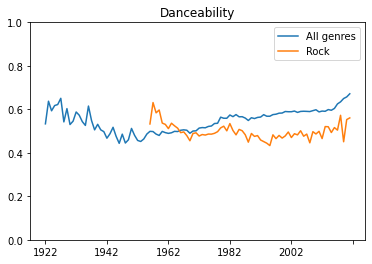

In [29]:
rock = pd.DataFrame.from_dict(results_popular['rock']['danceability'], orient='index', columns=['Rock'])
all_genres = pd.DataFrame.from_dict(results_popular['all']['danceability'], orient='index', columns=['All genres'])
plot = pd.concat((all_genres, rock), axis=1).plot(title="Danceability", ylim=(0,1))
fig = plot.get_figure()
fig.savefig("../img/audio_features_example.png")

## Save results

In [15]:
with open("../data/audio_features_by_genre.json", "w") as outfile: 
    json.dump(results_popular, outfile)